In [91]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
warnings.filterwarnings('ignore')
df = pd.read_csv("train.csv")

# Data Visualization

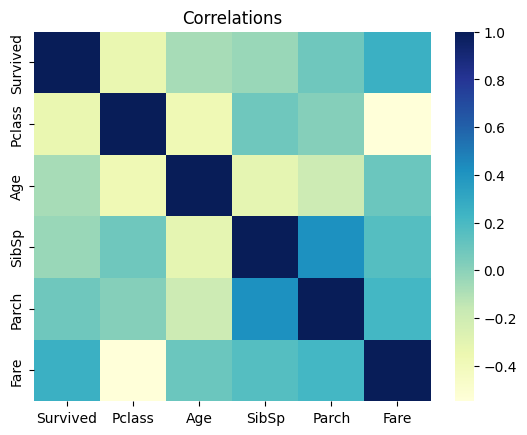

In [93]:
sns.heatmap(df[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]].corr(), cmap="YlGnBu")
plt.title("Correlations")
plt.show()

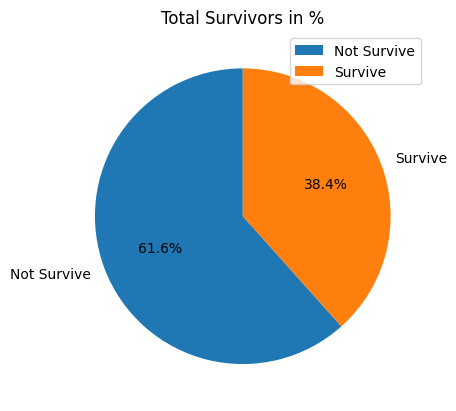

In [19]:
total_survived = df["Survived"].value_counts()
labels = ["Not Survive", "Survive"]
plt.pie(x=total_survived, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Total Survivors in %")
plt.legend()
plt.show()

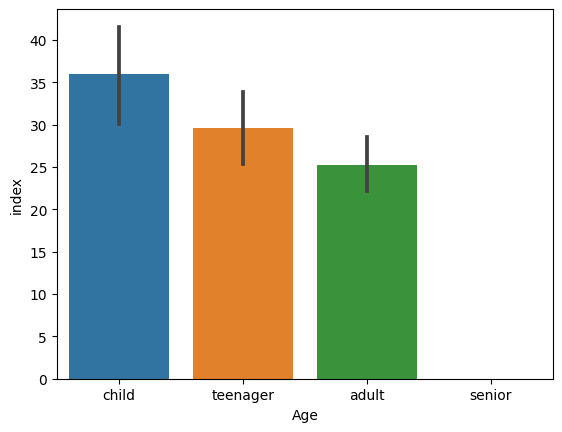

In [20]:
age_groups = df["Age"].value_counts()
age_groups_df = pd.DataFrame(pd.cut(age_groups, bins=[0, 12, 18, 65, 100], labels=["child", "teenager", "adult", "senior"])).reset_index()
sns.barplot(y="index", x="Age", data=age_groups_df)
plt.show()

<Axes: xlabel='Pclass', ylabel='Percent'>

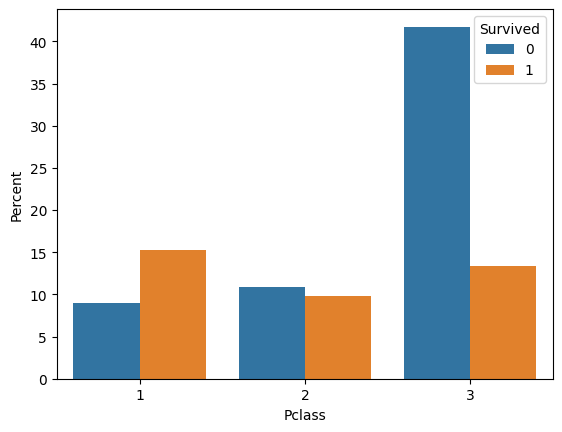

In [21]:
pclass_pct = df.groupby(["Pclass", "Survived"])["Survived"].count() / len(df) * 100
pclass_pct.name = "Percent"
pclass_pct = pclass_pct.reset_index()
sns.barplot(x="Pclass", y="Percent", data=pclass_pct, hue="Survived")

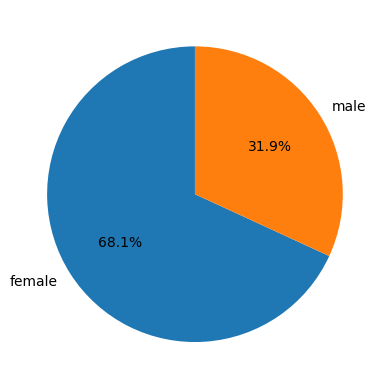

In [22]:
survived_by_gender = df.groupby("Sex")["Survived"].sum()
labels = ["female", "male"]
plt.pie(x=survived_by_gender, labels=labels, autopct="%1.1f%%", startangle=90)
plt.show()

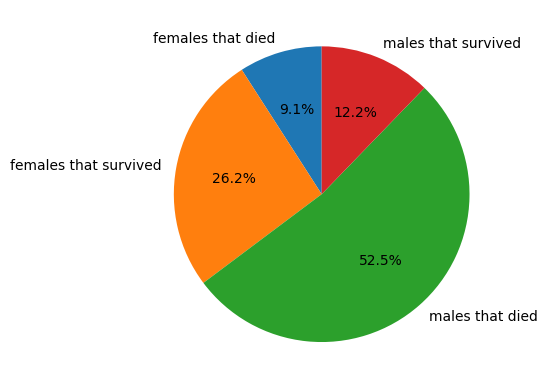

In [23]:
survived_by_gender = df.groupby(["Sex", "Survived"])["Survived"].count() / len(df) * 100
labels = ["females that died", "females that survived", "males that died", "males that survived"]
plt.pie(x=survived_by_gender, labels=labels, autopct="%1.1f%%", startangle=90)
plt.show()

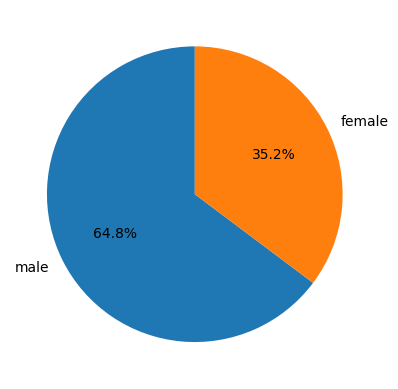

In [24]:
totat_amout_of_people_by_gender = df["Sex"].value_counts()
labels = ["male", "female"]
plt.pie(totat_amout_of_people_by_gender, labels=labels, startangle=90, autopct="%1.1f%%")
plt.show()

# Machine learning

In [94]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(df, df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = df.loc[train_indices]
    strat_test_set = df.loc[test_indices]

<Axes: >

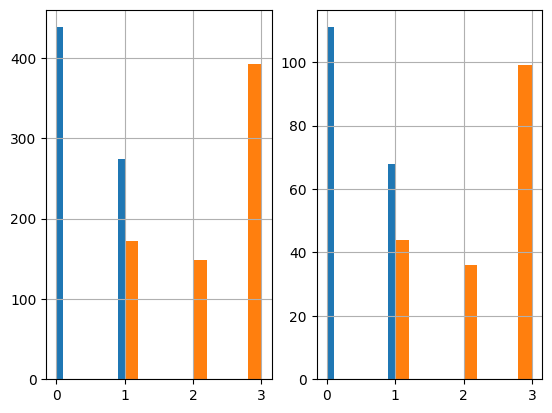

In [95]:
plt.subplot(1, 2, 1)

strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1, 2, 2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

## Preprocessing

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.interpolate import interp1d

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        age = X['Age'].values
        missing_mask = np.isnan(age)
        indices = np.arange(len(age))
        f = interp1d(indices[~missing_mask], age[~missing_mask], kind='linear', bounds_error=False, fill_value=1)
        age[missing_mask] = f(indices[missing_mask])
        return X

In [97]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
            
        return X

In [98]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [99]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureencoder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

strat_train_set = pipeline.fit_transform(strat_train_set)

In [100]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(columns="Survived")
y = strat_train_set["Survived"]

scaler = StandardScaler()
X_data_train = scaler.fit_transform(X)
y_data_train = y.to_numpy()

## Model tuning

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

forest_param_grid = {"n_estimators": [90, 100, 150], "max_depth": [None, 5, 10],"min_samples_split": [2, 3, 4]}
gbc_param_grid = {"learning_rate": [0.01, 1], "max_features": ["auto", "sqrt", "log2"], "subsample": [0, 1, 2]}
lr_param_grid = {"fit_intercept": [True, False], "intercept_scaling": [0, 10, 20], "warm_start": [True, False]}
lda_param_grid = {"solver": ["svd", "lsqr", "eigen"], "shrinkage": [None, "auto", 0.1, 0.3, 0.6, 0.9]}
svc_param_grid = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}


model_list = {
    "Random_Forest": GridSearchCV(estimator=RandomForestClassifier(), param_grid=forest_param_grid, cv=5, scoring="accuracy", return_train_score=True),
    "Gradient_Boosting": GridSearchCV(estimator=GradientBoostingClassifier(random_state=0, criterion="squared_error"), param_grid=gbc_param_grid),
    "Logistic_Regression": GridSearchCV(LogisticRegression(random_state=0), param_grid=lr_param_grid),
    "SVC": GridSearchCV(SVC(random_state=0),param_grid=svc_param_grid),
    "LDA": GridSearchCV(LinearDiscriminantAnalysis(), param_grid=lda_param_grid),
    "XGB": XGBClassifier()
}


In [102]:
strat_test_set = pipeline.fit_transform(strat_test_set)
X = strat_test_set.drop(columns="Survived")
y = strat_test_set["Survived"]

X_data_test = scaler.fit_transform(X)
y_data_test = y.to_numpy()

## Model evaluation

In [103]:
from sklearn.metrics import accuracy_score, recall_score, r2_score, precision_score, classification_report, confusion_matrix, log_loss, matthews_corrcoef, roc_curve, cohen_kappa_score

# todo: understand every metric and use them

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    confusion = confusion_matrix(y_true, y_pred)
    log = log_loss(y_true, y_pred)
    matthews= matthews_corrcoef(y_true, y_pred)
    return accuracy, recall, r2, precision, confusion, log, matthews
    

In [104]:
score = {}
for model in model_list:
    model_list[model].fit(X_data_train, y_data_train)
    prediction = model_list[model].predict(X_data_test)
    predicted_score = evaluate(y_data_test, prediction)
    score[model] = predicted_score

score_df = pd.DataFrame(score, index=["accuracy", "recall", "r2", "precision", "confusion", "log", "matthews"])
score_df.to_csv("predicted_score.csv")

# Meta Estimator

In [105]:
from sklearn.ensemble import VotingClassifier

votingclf = VotingClassifier(estimators=list(model_list.items()))
votingclf.fit(X_data_train, y_data_train)

VotingClassifier(estimators=[('Random_Forest',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(),
                                           param_grid={'max_depth': [None, 5,
                                                                     10],
                                                       'min_samples_split': [2,
                                                                             3,
                                                                             4],
                                                       'n_estimators': [90, 100,
                                                                        150]},
                                           return_train_score=True,
                                           scoring='accuracy')),
                             ('Gradient_Boosting',
                              GridSearchCV(estimator=GradientBoostingClassifier(criterion='squared_error',
                                                                                random_state=0),...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

# Final Prediciton

In [118]:
titanic_test_data = pd.read_csv("test.csv")

In [114]:
final_test_data = pipeline.fit_transform(titanic_test_data)
final_test_data.fillna(method="ffill", inplace=True)
X_data_final_test = scaler.fit_transform(final_test_data)

In [120]:
predictions = votingclf.predict(X_data_final_test)

In [123]:
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("predictions.csv", index=False)